# Step 3: K-Medoids Clustering
This notebooks considers the set-up and analysis for the third step of the thesis. First, some data preperation such as the import of files is done. Then, the selecting of the variables is done and the clustering analysis takes place. 

## 0. Data preperation 

### 0.1 Import Packages

In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
from adjustText import adjust_text
import os
from matplotlib.patches import Patch, ConnectionPatch
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Ignoring unnecessary warnings
warnings.filterwarnings("ignore")

### 0.2 Import files

In [3]:
#Reading the csv files with the split of MSOA regions
#This is Norfolk/Suffolk
filtered_ns = pd.read_csv('../datafiles/filtered_ns.csv')
#Somerset
filtered_somerset= pd.read_csv('../datafiles/filtered_somerset.csv')
#London
filtered_london=pd.read_csv('../datafiles/filtered_london.csv')

In [ ]:
#Reading the survey data file file
survey_data = pd.read_csv('../datafiles/grouped_survey.csv')
#gdf file
gdf = gpd.read_file("../shapefiles/UK_plot/infuse_msoa_lyr_2011.shp")

In [ ]:
#Now the base regions MSOA name lists
ns_region = pd.read_csv('../datafiles/norfolk_suffolk_region.csv')
#Somerset
somerset_region= pd.read_csv('../datafiles/somerset_region.csv')
#London
london_region=pd.read_csv('../datafiles/london_region.csv')
#The London boroughs, for better visualisation 
london_borough=gpd.read_file('../shapefiles/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

### 0.3 Define colours

In [4]:
cluster_colors ={ 
    0: '#4e6d91', 
    1: '#90ac8c', 
    2: '#f4c539', 
    3: '#e78942', 
    4: '#d7384e'
}

In [5]:
# Convert the cluster_colors dictionary to a list of colors for implementing in the maps of the clustering analysis 
color_list = [color for key, color in sorted(cluster_colors.items())]

In [6]:
# Create a custom colormap from the color list
custom_cmap = LinearSegmentedColormap.from_list("custom_colors", color_list)

In [7]:
custom_cmap_list = ListedColormap(color_list)

### 0.4 Functions

In [8]:
def compute_silhouette(df): 
    # This function is to compute the silhouette score 

    #Create a list for the computed scores
    s_scores = []

    k_values = list(range(2, 15))
    # Compute the score for a range from 2 to 14 number of clusters
    for k in k_values:
        #Perform KMedoids for each k with manhattan distance and k-medoids initialisation
        km = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0, max_iter=300)
        label = km.fit_predict(df)

        #Appending scores for each k to list
        score = silhouette_score(df, label, metric='manhattan')
        s_scores.append(score)
        
        #Printing the silhouette score for each k to find optimal k
        #and round 3 digits
        print(f'k = {k}, The silhouette score is = {score:.3f}')

In [9]:
def dissimilarity_elbow(X, k):
    #This function finds the dissimilarity by using within-cluster total distance 
    # using manhattan metric
    kmedoids = KMedoids(n_clusters=k, metric='manhattan',  init='k-medoids++', random_state=0, max_iter=300)
    kmedoids.fit(X)
    
    # Getting the Manhattan distance 
    distances = pairwise_distances(X, kmedoids.cluster_centers_, metric='manhattan')

    #Assess the of the total dissimilarity cost 
    cost = sum(distances[i, label] for i, label in enumerate(kmedoids.labels_))

    #Return the cost 
    return cost

In [10]:
def elbow_method(df):
    
    # This functioon creates a plot for the elbow method by using the 
    # dissimilarity_elbow function from above for different values of k
    
    # Collecting the dissimilarity cost for different values of k
    costs_k= []
    
    for k in range(2, 15):
        #For different ranges of k, the dissimilarity cost is calculated
        cost = dissimilarity_elbow(df, k)

        #Append the cost in the list
        costs_k.append(cost)
    
    # Plotting the elbow curve for each k
    title = 'Elbow method check for k-Medoids'
    plt.plot(range(2, 15), costs_k, marker='o', color='#4e6d91')
    plt.title(title)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Total dissimilarity - Cost")

    #Creating a path and saving the figure
    full_path = os.path.join('../figures/step3', title )
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()

In [11]:
def cluster_region(df, k, original):
    
    # Applying K-Medoids clustering on the dataframe 
    # for the pre-determined number of k
    kmedoids = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0, max_iter=300)
    kmedoids.fit(df)

    # Getting the medoids and labels of the clusters
    #I am setting the results to the original dataframe
    # Without scaled values for easier interpretation
    medoids = kmedoids.cluster_centers_
    original['Cluster'] = kmedoids.labels_
    original['Cluster']=original['Cluster'].astype(int)

    #Returning the original dataframe with the cluster labels
    return original

In [12]:
def make_cluster_plot(base, df, title, folder='../figures/step3'):
    #This function creates plots for each region based including
    #the cluster label that is most common cluster label in 
    # the region
    all_clusters =[0,1,2,3,4]
    cluster_colors=dict(zip(all_clusters, custom_cmap_list.colors))
    # Setting up figure and main axes
    fig, main_ax = plt.subplots(figsize=(14, 14))

    #Sets the position and sixe of the axes
    main_ax.set_position([0.09, 0.09, 0.45, 0.45])
    
    # Plotting base region, without the clusters
    base.plot(ax=main_ax, edgecolor='black',facecolor='#f0f0f0', linewidth=0.5, alpha=0.5)

      
    # Plotting unique values of the clusters including a legend and no boundary
    df.plot(column='Cluster', categorical=True, legend=False, linewidth=0.2, edgecolor='black', 
                    cmap=custom_cmap, legend_kwds={'loc': 'upper left', 'title': 'Clusters', 'fontsize': 14}, 
                    ax=main_ax)
    
    #Setting axes off on the main plot
    main_ax.set_axis_off()
    # Creating custom legend handles that includes all clusters
    legend_handles = [
        Patch(color=cluster_colors[c], label=f"{c}")
        for c in all_clusters
    ]
    
    # Add custom legend
    main_ax.legend(handles=legend_handles,
                   title='Cluster',
                   loc='upper left',
                   fontsize=14,
                   title_fontsize=14)
    
    # Creating inset axes
    inset= inset_axes(main_ax, width="120%", height="120%", bbox_to_anchor=(1.1, 0.5, 1.1, 1.1), bbox_transform=main_ax.transAxes, borderpad=1)

    #Plotting the cluster plots in the inset axes
    df.plot(ax=inset, column='Cluster', categorical=True, legend=True, linewidth=0.2, edgecolor='black', 
                    cmap=custom_cmap, legend_kwds={'loc': 'upper left', 'title': 'Clusters'})
    
    #Removing ticks on the inset axes
    inset.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    #Removing the legend of the inset axes
    inset.legend().remove()
    
    #Determining label column based on the base region
    label_column = 'MSOA name' if base.equals(gdf_ns) or base.equals(gdf_somerset) else 'LA name'

    #Dropping duplicate geometries if there are any for labelling
    df_label = df.drop_duplicates(subset=['geometry', label_column])
    
    texts = [] 
    #For each MSOA region, the centre of the region is identified and the
    #corresponding MSOA name is identified. The text is then added to the inset plot
    for idx, row in df_label.iterrows():
        x, y = row['geometry'].centroid.coords[0]
        label = row['MSOA name'] if base.equals(gdf_ns) or base.equals(gdf_somerset) else row['LA name']
        text = inset.text(x , y, label, fontsize=11, weight='bold', ha='right', color='black', clip_on=False)
        texts.append(text)
    
    # This automatically adjust positions and draw arrows
    adjust_text(texts,  only_move={'points': 'y', 'text': 'xy'}, expand_text=(1.6, 1.7), arrowprops=dict(arrowstyle='-', color='black', lw=0.4, linestyle='--'))

    # Draws a line from the inset axis to the main plot
    centroid = df.geometry.centroid.iloc[0]
    main_pt = (centroid.x,centroid.y)  
    #Shifting the inset
    inset_pt = (centroid.x - 9000,centroid.y - 5000 )
    #Connects a point on one axes to another
    con= ConnectionPatch(xyA=inset_pt, coordsA=inset.transData,
                           xyB=main_pt, coordsB=main_ax.transData,
                           color='#d7384e', linewidth=0.4, linestyle='--')
    #Adds the inset line
    fig.add_artist(con)

    #Sets title
    main_ax.set_title(title, fontsize=20)

    #Create filepath and save figure
    full_path = os.path.join(folder, title)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    # Display the map
    plt.show()

In [13]:
def to_latex(df): 
    #Printing the results to a Latex format and showing the results dataframe of the clustering
    aggregate_result=df.groupby('Cluster').agg(['count', 'mean', 'median', 'std']).round(2).T
    latex_str=aggregate_result.to_latex(index=True, float_format=lambda x: f"{x:.2f}".rstrip('0').rstrip('.'))
    print(latex_str)
    return aggregate_result

### 0.5 Data selecting, subsetting and renaming

In [14]:
#Renaming in gdf dataframe
gdf=gdf.rename(columns={'geo_label': 'MSOA name'})
#Choosing only geometry in gdf 
gdf=gdf[['MSOA name', 'geometry']]

In [15]:
#Renaming in london borough
london_borough=london_borough.rename(columns={'NAME': 'LA name'})

In [16]:
#Only selecting the necessary columns out of london borough and london region 
london_borough=london_borough[['LA name', 'geometry']]
london_region=london_region[['MSOA name', 'LA name']]

I want to subset the geodataframes for the three regions first. 

In [17]:
#Only selecting the regions of Norfolk/Suffolk
gdf_ns=gdf[gdf['MSOA name'].isin(ns_region['MSOA name'])]
#Somerset
gdf_somerset=gdf[gdf['MSOA name'].isin(somerset_region['MSOA name'])]

In [ ]:
#I need to merge to be able to filter London data
filtered_london = london_region.merge(filtered_london, on = 'MSOA name', how='right')
#Merge with London Borough data to be able to merge on LA name geometry
merged_london=london_borough.merge(filtered_london, on='LA name', how='right')

## 1. Preparing the variables for clustering


### 1.1 Selecting the variables

Now the variables for the clustering analysis can be selected

In [18]:
#Selecting the columns
selected_columns=[ 'Trust Prime Minister' , 'Trust Government Representative', 'Trust Family and Friends', 'Trust General Media', 'Trust Social Media', 
                  'Household Income', 'Household Savings','Multiple Incomes', 'Age Group', 'Any measure done non-structural', 'Any measure done structural','Any measure plan non-structural', 'Any measure plan structural' , 'Flood Experience'] 


In [19]:
survey_data_count=survey_data[survey_data[selected_columns].isin([98, 99]).any(axis=1)].shape[0]

In [20]:
#Checking the number of entries of all columns that have 98 (Don't know) or prefer not to say (99)
print(f"The total dataframe of all regions with selected columns has the following number rows containing 98 or 99: {survey_data_count}")

The total dataframe of all regions with selected columns has the following number rows containing 98 or 99: 275


### 1.2 Transforming variables
I have decided to remove the entries with unwanted values, such as 98 and 99. 

In [21]:
#Creating a new dataframe with the selected columns
selected_survey=survey_data[selected_columns]
#Deleting the entries with 98,99 in them
selected_survey = selected_survey[~selected_survey.isin([98, 99]).any(axis=1)]
#Ensuring all columns have type float
selected_survey = selected_survey.astype(float)

In [22]:
print(f"The selected_survey dataframe has: {selected_survey.shape[0]} entries")

The selected_survey dataframe has: 468 entries


In [23]:
#Merging the survey columns with the gdf for later use
merged_survey=gdf.merge(survey_data,  on = 'MSOA name', how='right')

### 1.3 Scaling the variables
I want to rescale the variables for easier interpretation and preventing dominance by larger-scale features. 

In [24]:
# Define the scale for variable
rescale = {
    'Trust Prime Minister': (1,5),
    'Trust Government Representative': (1,5), 
    'Trust Family and Friends': (1,5), 
    'Trust General Media': (1,5), 
    'Trust Social Media': (1,5), 
    'Household Income': (1, 5),  
    'Household Savings': (1, 7),  
    'Unemployment Time': (1, 4), 
    'Multiple Incomes': (0,1),
    'Age Group': (1,5),
    'Any measure done non-structural': (0,1), 
    'Any measure done structural': (0,1), 
    'Any measure plan non-structural': (0,1),
    'Any measure plan structural': (0,1),
    'Flood Experience': (0,1)
}

In [25]:
# Normalising all columns
survey_data_scale = selected_survey.copy()
#Manually normalising the columns so that it returns a dataframe 
for column in survey_data_scale.columns:
    min_value, max_value = rescale[column]
    survey_data_scale[column] = (survey_data_scale[column] - min_value) / (max_value - min_value)

## 2. K-Medoids clustering
First assessing the optimal number of clusters by using the silhouette score and the elbow method.

In [26]:
compute_silhouette(survey_data_scale)

k = 2, The silhouette score is = 0.207
k = 3, The silhouette score is = 0.176
k = 4, The silhouette score is = 0.118
k = 5, The silhouette score is = 0.149
k = 6, The silhouette score is = 0.129
k = 7, The silhouette score is = 0.111
k = 8, The silhouette score is = 0.131
k = 9, The silhouette score is = 0.121
k = 10, The silhouette score is = 0.124
k = 11, The silhouette score is = 0.119
k = 12, The silhouette score is = 0.121
k = 13, The silhouette score is = 0.123
k = 14, The silhouette score is = 0.127


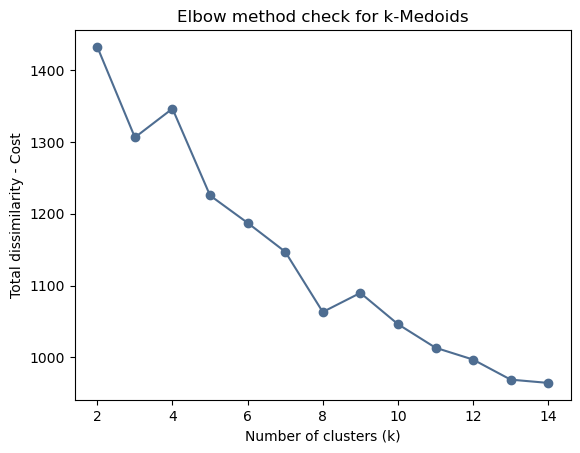

In [27]:
elbow_method(survey_data_scale)

In [28]:
#Optimal number of clusters is chosen to 5, hence the clustering is performed
result_clustering=cluster_region(survey_data_scale, 5, selected_survey)

In [29]:
to_latex(result_clustering)

\begin{tabular}{llrrrrr}
\toprule
 & Cluster & 0 & 1 & 2 & 3 & 4 \\
\midrule
\multirow[t]{4}{*}{Trust Prime Minister} & count & 55 & 62 & 199 & 46 & 106 \\
 & mean & 1.09 & 2.13 & 2.28 & 3.24 & 2.06 \\
 & median & 1 & 2 & 2 & 3 & 2 \\
 & std & 0.29 & 1.15 & 1.27 & 0.97 & 1.19 \\
\cline{1-7}
\multirow[t]{4}{*}{Trust Government Representative} & count & 55 & 62 & 199 & 46 & 106 \\
 & mean & 1.64 & 3 & 2.88 & 3.65 & 2.98 \\
 & median & 1 & 3 & 3 & 4 & 3 \\
 & std & 1.11 & 1.21 & 1.19 & 0.85 & 1.11 \\
\cline{1-7}
\multirow[t]{4}{*}{Trust Family and Friends} & count & 55 & 62 & 199 & 46 & 106 \\
 & mean & 3.27 & 3.11 & 3.61 & 3.72 & 3.57 \\
 & median & 3 & 3 & 4 & 4 & 4 \\
 & std & 1.19 & 1.06 & 1.03 & 0.93 & 1.02 \\
\cline{1-7}
\multirow[t]{4}{*}{Trust General Media} & count & 55 & 62 & 199 & 46 & 106 \\
 & mean & 1.87 & 2.48 & 2.65 & 3.65 & 2.75 \\
 & median & 1 & 2 & 3 & 4 & 3 \\
 & std & 1.02 & 1 & 1 & 0.77 & 1.02 \\
\cline{1-7}
\multirow[t]{4}{*}{Trust Social Media} & count & 55 & 62 &

Cluster                                     0      1       2      3       4
Trust Prime Minister            count   55.00  62.00  199.00  46.00  106.00
                                mean     1.09   2.13    2.28   3.24    2.06
                                median   1.00   2.00    2.00   3.00    2.00
                                std      0.29   1.15    1.27   0.97    1.19
Trust Government Representative count   55.00  62.00  199.00  46.00  106.00
                                mean     1.64   3.00    2.88   3.65    2.98
                                median   1.00   3.00    3.00   4.00    3.00
                                std      1.11   1.21    1.19   0.85    1.11
Trust Family and Friends        count   55.00  62.00  199.00  46.00  106.00
                                mean     3.27   3.11    3.61   3.72    3.57
                                median   3.00   3.00    4.00   4.00    4.00
                                std      1.19   1.06    1.03   0.93    1.02
Trust General Media             count   55.00  62.00  199.00  46.00  106.00
                                mean     1.87   2.48    2.65   3.65    2.75
                                median   1.00   2.00    3.00   4.00    3.00
                                std      1.02   1.00    1.00   0.77    1.02
Trust Social Media              count   55.00  62.00  199.00  46.00  106.00
                                mean     1.58   1.81    1.71   3.46    2.27
                                median   1.00   2.00    1.00   3.50    2.00
                                std      1.03   0.85    0.86   0.96    1.12
Household Income                count   55.00  62.00  199.00  46.00  106.00
                                mean     3.00   4.21    4.05   3.61    2.16
                                median   3.00   5.00    4.00   4.00    2.00
                                std      1.41   1.15    1.13   1.45    1.22
Household Savings               count   55.00  62.00  199.00  46.00  106.00
                                mean     3.98   6.10    5.81   4.02    1.92
                                median   4.00   7.00    7.00   4.00    1.00
                                std      2.59   1.84    1.97   2.28    1.66
Multiple Incomes                count   55.00  62.00  199.00  46.00  106.00
                                mean     0.16   0.85    0.85   0.33    0.05
                                median   0.00   1.00    1.00   0.00    0.00
                                std      0.37   0.36    0.36   0.47    0.21
Age Group                       count   55.00  62.00  199.00  46.00  106.00
                                mean     2.60   3.29    3.17   2.22    2.65
                                median   2.00   4.00    3.00   2.00    3.00
                                std      0.95   1.14    1.14   1.03    0.89
Any measure done non-structural count   55.00  62.00  199.00  46.00  106.00
                                mean     0.22   0.84    0.79   0.22    0.83
                                median   0.00   1.00    1.00   0.00    1.00
                                std      0.42   0.37    0.41   0.42    0.38
Any measure done structural     count   55.00  62.00  199.00  46.00  106.00
                                mean     0.04   0.13    0.08   0.17    0.12
                                median   0.00   0.00    0.00   0.00    0.00
                                std      0.19   0.34    0.27   0.38    0.33
Any measure plan non-structural count   55.00  62.00  199.00  46.00  106.00
                                mean     0.65   0.94    0.05   0.76    0.18
                                median   1.00   1.00    0.00   1.00    0.00
                                std      0.48   0.25    0.22   0.43    0.39
Any measure plan structural     count   55.00  62.00  199.00  46.00  106.00
                                mean     0.09   0.03    0.04   0.30    0.09
                                median   0.00   0.00    0.00   0.00    0.00
                                std      0.29   

## 3.Plotting the clusters
Even though I clustered all regions together, I plot them seperately for visibility. First I need to do some data alterations and merging to be able to plot the mode of cluster label of the region.

In [30]:
#Setting the cluster labels from the selected_survey (the original dataframe without the scaling) to the merged survey with the geodata
merged_survey['Cluster']=selected_survey['Cluster']
#Dropping Nan values
merged_survey = merged_survey.dropna(subset=['Cluster'])
#Setting type integer to the column
merged_survey['Cluster'] = merged_survey['Cluster'].astype(int)

I only want to plot one cluster label, the cluster label that occurs the most for that region (mode). That is why I group by the region, and then take the mode of the cluster labels that belong to that region. 

In [31]:
plotting_clusters=(merged_survey.groupby('MSOA name')['Cluster'].agg(lambda x: x.mode().iloc[0])  # In case of multiple modes, take the first
               .reset_index()
)

In [32]:
#This is what the dataframe looks like
plotting_clusters.head()

,MSOA name,Cluster
0,Babergh 011,2
1,Barking and Dagenham 007,3
2,Barking and Dagenham 010,4
3,Barking and Dagenham 011,2
4,Barking and Dagenham 014,2


### Norfolk/Suffolk coast

In [33]:
#I only want the MSOA names belonging to Norfolk/Suffolk coast with their cluster labels
merged_ns=plotting_clusters[plotting_clusters['MSOA name'].isin(filtered_ns['MSOA name'])]

In [34]:
#I am merging merged_ns with geodata
plot_ns=gdf_ns.merge(merged_ns,  on = 'MSOA name', how='right')

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


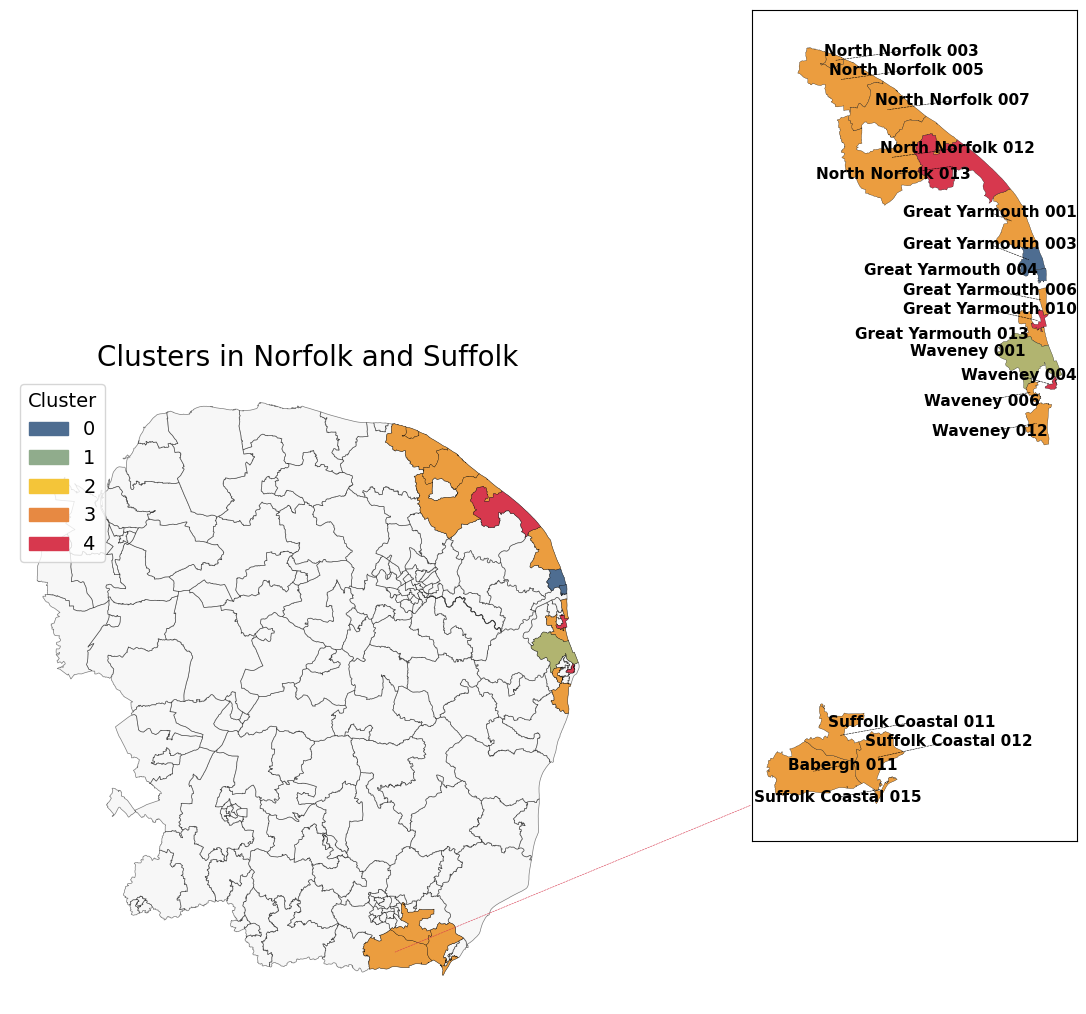

In [35]:
make_cluster_plot(gdf_ns, plot_ns, 'Clusters in Norfolk and Suffolk')

### Somerset

In [36]:
#Only want the MSOA names and cluster labels belonging to Somerset
merged_somerset=plotting_clusters[plotting_clusters['MSOA name'].isin(filtered_somerset['MSOA name'])]

In [37]:
#Merging somerset names with geodata from somerset
plot_somerset=gdf_somerset.merge(merged_somerset,  on = 'MSOA name', how='right')

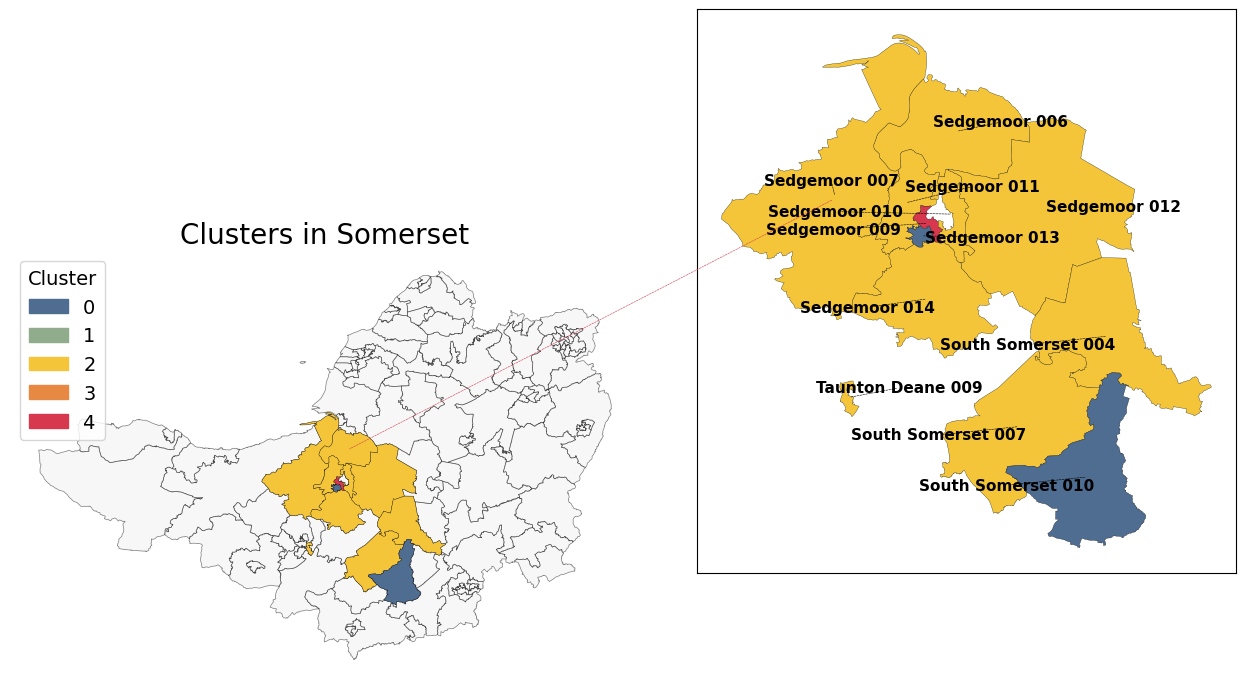

In [38]:
make_cluster_plot(gdf_somerset, plot_somerset, 'Clusters in Somerset')

### London
London is a bit trickier than the other two regions, as I need to merge with the LA names instead of MSOA. 

In [39]:
#Selecting columns and renaming before merge
filtered_london_cluster=merged_london[['LA name', 'geometry', 'MSOA name', 'ID']]
filtered_london_cluster=filtered_london_cluster.rename(columns={'geometry': 'geometry LA'})

In [40]:
#Merging with plotting clusters (has the label names)
merged_london_final=filtered_london_cluster.merge(plotting_clusters, on='MSOA name', how='right')

In [41]:
#Making sure the areas coincide with the filtered london cluster datafrane
merged_london_final_new=merged_london_final[merged_london_final['ID'].isin(filtered_london_cluster['ID'])]

In [42]:
#Aggregating the results by taking the mode, this time taking the LA name instead of the MSOA name
plot_london=(merged_london_final_new.groupby('LA name').agg({'Cluster': lambda x: x.mode().iloc[0], 'geometry LA': 'first'})  # In case of multiple modes, take the first
               .reset_index()
)

In [43]:
#Renaming the geometry column, to be able to use the same make_cluster_plot function as above
plot_london.rename(columns={'geometry LA': 'geometry'}, inplace = True)

In [44]:
#After aggregating by LA name the geometry crs was lost, so need to set that back
plot_london = GeoDataFrame(plot_london, geometry='geometry', crs=merged_london.crs)

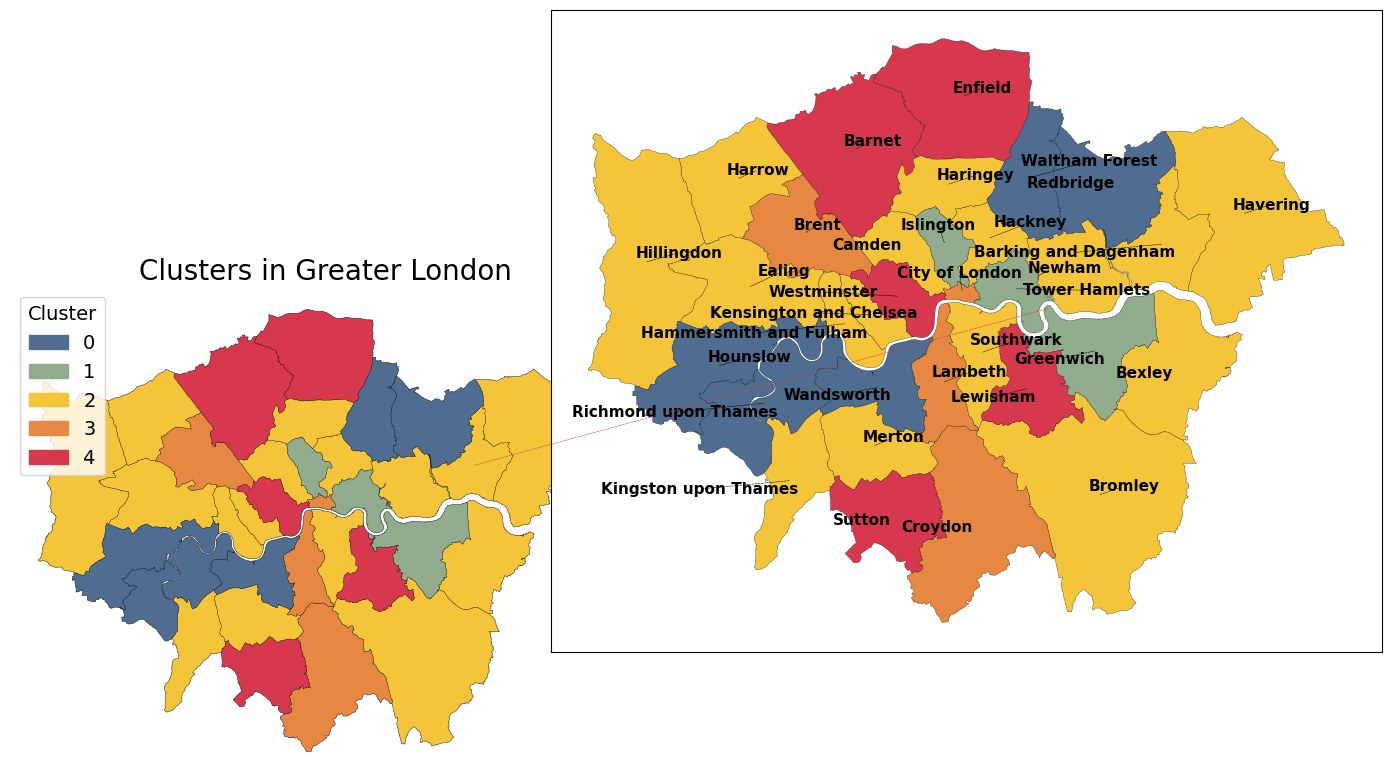

In [45]:
#Creating plot
make_cluster_plot(london_borough, plot_london, 'Clusters in Greater London')